In [1]:
from pennylane import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
import tensorflow as tf
import seaborn as sns

from utils.tools import get_dataset, visualise_data

2025-04-17 12:04:18.873850: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744855458.889992   24666 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744855458.894996   24666 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744855458.907573   24666 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744855458.907584   24666 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744855458.907586   24666 computation_placer.cc:177] computation placer alr

I0000 00:00:1744855461.248853   24666 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10493 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:02:00.0, compute capability: 6.0


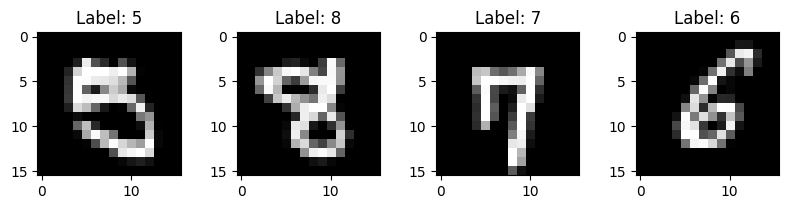

In [2]:
digits = [5,8,7,6]
n_px = 16

(x_train, y_train), (x_test, y_test) = get_dataset(digits=digits, n_px=n_px)

# show one image from each class
x_vis = [(x_train[y_train==digit])[np.random.choice(range(10))] for digit in digits] 
y_vis = range(len(digits))

visualise_data(digits, x_vis, y_vis)

### Classical model

In [3]:
def create_classical_model(n_px):
    model = keras.Sequential([
        keras.Input(shape=(n_px,n_px,1)),
        keras.layers.Flatten(),
        # select the dense layer outputs to match quantum model characteristics
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])

    return model

def create_classical_model_CNN(n_px):
    model = keras.Sequential([
        keras.Input(shape=(n_px,n_px,1)),
        keras.layers.Conv2D(32, [3,3], activation='relu'),
        keras.layers.Conv2D(64, [3, 3], activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.25),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])

    return model

In [4]:
classical_model = create_classical_model(n_px)
classical_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)
classical_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         2,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,146 (8.38 KB)

 Trainable params: 2,146 (8.38 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
classical_model_CNN = create_classical_model_CNN(n_px)
classical_model_CNN.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)
classical_model_CNN.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,146 (1.20 MB)

 Trainable params: 315,146 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
c_history = classical_model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    batch_size=30,
    epochs=20,
    verbose=1
)

# classical_model_results = classical_model.evaluate(x_test, y_test)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9986 - loss: 0.0162 - val_accuracy: 0.9450 - val_loss: 0.2073
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0150 - val_accuracy: 0.9500 - val_loss: 0.2016
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0142 - val_accuracy: 0.9500 - val_loss: 0.2010
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0142 - val_accuracy: 0.9500 - val_loss: 0.1993
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0143 - val_accuracy: 0.9500 - val_loss: 0.2002
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0169 - val_accuracy: 0.9500 - val_loss: 0.2021
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0142 - val_accuracy: 0.9500 - val_loss: 0.1987
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0136 - val_accuracy: 0.9500 - val_loss

In [10]:
CNN_history = classical_model_CNN.fit(x_train,
                   y_train,
                   batch_size=30,
                   epochs=20,
                   verbose=1,
                   validation_data=(x_test, y_test))

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.9950 - val_loss: 0.0377
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0043 - val_accuracy: 0.9950 - val_loss: 0.0376
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9970 - loss: 0.0051 - val_accuracy: 0.9950 - val_loss: 0.0510
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 4.0961e-04 - val_accuracy: 0.9950 - val_loss: 0.0522
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9975 - loss: 0.0091 - val_accuracy: 0.9900 - val_loss: 0.0668
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.3786e-04 - val_accuracy: 0.9900 - val_loss: 0.0637
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.5607e-04 - val_accuracy: 0.9900 - val_loss: 0.0629
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.8263e-04 - val_accuracy: 0

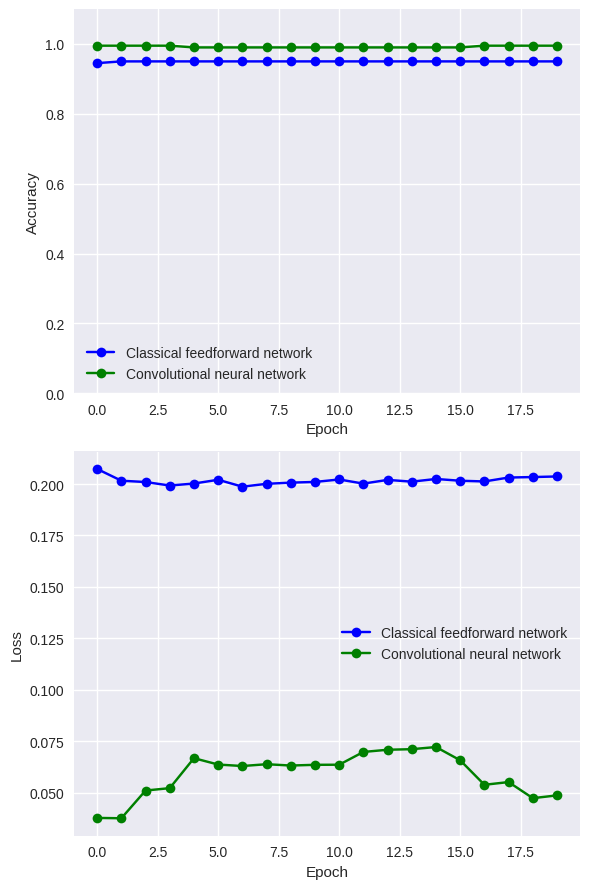

In [11]:
plt.style.use("seaborn-v0_8")
fig, ax = plt.subplots(2, 1, figsize=(6,9))

ax[0].plot(c_history.history["val_accuracy"], "-ob", label="Classical feedforward network")
ax[0].plot(CNN_history.history["val_accuracy"], "-og", label="Convolutional neural network")
ax[0].set_ylabel("Accuracy")
ax[0].set_ylim([0, 1.1])
ax[0].set_xlabel("Epoch")
ax[0].legend()

ax[1].plot(c_history.history["val_loss"], "-ob", label="Classical feedforward network")
ax[1].plot(CNN_history.history["val_loss"], "-og", label="Convolutional neural network")
ax[1].set_ylabel("Loss")
# ax[1].set_ylim(top=2.5)
ax[1].set_xlabel("Epoch")
ax[1].legend()

plt.tight_layout()
plt.show()

For quantum model see other notebook.

In [29]:
X_train = np.reshape(x_train, (len(x_train), n_px, n_px))
X_test = np.reshape(x_test, (len(x_test), n_px, n_px))
Y_train = y_train
Y_test = y_test

print('X')
print(f'Shape : {X_train.shape}')
print(f'dType : {X_train.dtype}')
print(f'pyType: {type(X_train)}')

print('Y')
print(f'Shape : {Y_train.shape}')
print(f'dType : {Y_train.dtype}')
print(f'pyType: {type(Y_train)}')

X
Shape : (1000, 16, 16)
dType : float32
pyType: <class 'pennylane.numpy.tensor.tensor'>
Y
Shape : (1000,)
dType : uint8
pyType: <class 'numpy.ndarray'>


## Adversarial attack

In [24]:
def pgd(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = np.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [27]:
### Illustrate attacked images
delta = pgd(classical_model_CNN, X_train[0:50,:], y_train[0:50], 0.1, 1e4, 1000)
yp = classical_model_CNN(X_train + delta)
# plot_images(X+delta, y, yp, 3, 6)

TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not tensorflow.python.framework.ops.EagerTensor

In [23]:
X_train[0:50,:].shape

(50, 16, 16)

In [26]:
import torch.nn as nn

## PyTorch

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [35]:
digits = [5, 8, 7, 6]
n_px = 16
train_size = 1000
test_size = 200
batch_size = 64
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
# --- DATASET ---
def get_dataset(digits=[3, 5], n_px=8, train_size=1000, test_size=200):
    transform = transforms.ToTensor()
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    def filter_and_resize(dataset, digits, size, n_px):
        data = [(img, label) for img, label in dataset if label in digits]
        np.random.shuffle(data)
        data = data[:size]

        imgs, labels = zip(*data)
        resized_imgs = []
        for img in imgs:
            img_pil = transforms.ToPILImage()(img)
            img_resized = transforms.Resize((n_px, n_px))(img_pil)
            resized_imgs.append(transforms.ToTensor()(img_resized))

        x = torch.stack(resized_imgs)
        y = torch.tensor([digits.index(label) for label in labels])
        return x, y

    x_train, y_train = filter_and_resize(mnist_train, digits, train_size, n_px)
    x_test, y_test = filter_and_resize(mnist_test, digits, test_size, n_px)
    return (x_train, y_train), (x_test, y_test)

# --- VISUALIZATION ---
def visualise_data(digits, x_data, y_data):
    fig, axes = plt.subplots(1, len(digits), figsize=(10, 2))
    for i, ax in enumerate(axes):
        ax.imshow(x_data[i].squeeze(), cmap='gray')
        ax.set_title(f"Digit: {digits[y_data[i]]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

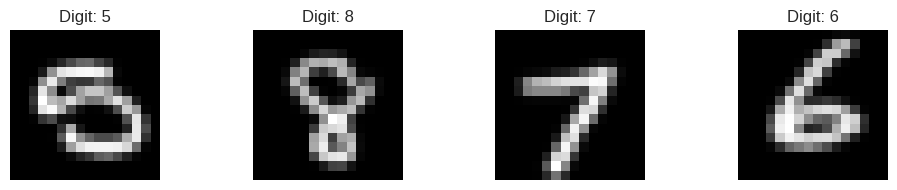

In [37]:
# Load dataset
(x_train, y_train), (x_test, y_test) = get_dataset(digits=digits, n_px=n_px)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

x_vis = [x_train[y_train == i][torch.randint(0, 10, (1,))] for i in range(len(digits))]
y_vis = list(range(len(digits)))
visualise_data(digits, x_vis, y_vis)

In [38]:
# --- MODEL ---
class ClassicalCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * (n_px // 2) * (n_px // 2), 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.fc1(x), dim=1)

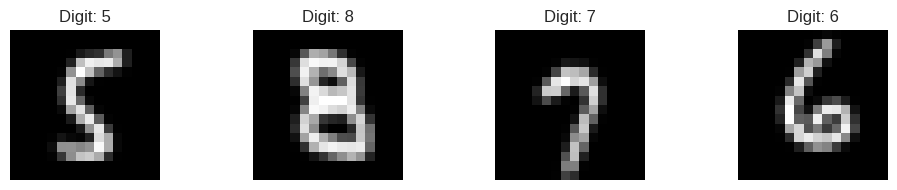

Epoch 1/10
Test Accuracy: 0.7200
Epoch 2/10
Test Accuracy: 0.7950
Epoch 3/10
Test Accuracy: 0.8550
Epoch 4/10
Test Accuracy: 0.9300
Epoch 5/10
Test Accuracy: 0.9150
Epoch 6/10
Test Accuracy: 0.9450
Epoch 7/10
Test Accuracy: 0.9450
Epoch 8/10
Test Accuracy: 0.9500
Epoch 9/10
Test Accuracy: 0.9550
Epoch 10/10
Test Accuracy: 0.9500


In [33]:
# --- TRAINING ---
def train(model, loader, optimizer, criterion):
    model.train()
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# --- TESTING ---
def test(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    accuracy = correct / len(loader.dataset)
    print(f'Test Accuracy: {accuracy:.4f}')

# --- RUN ---
model = ClassicalCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train(model, train_loader, optimizer, criterion)
    test(model, test_loader)


### With attack

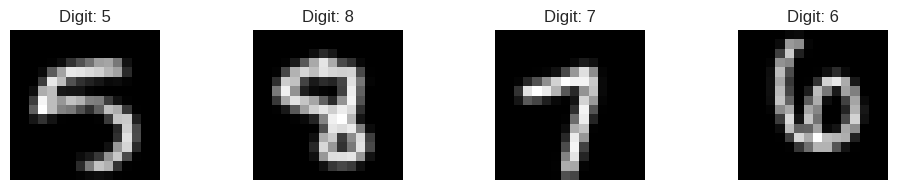

Epoch 1/10
Test Accuracy: 0.7300
Epoch 2/10
Test Accuracy: 0.8950
Epoch 3/10
Test Accuracy: 0.8950
Epoch 4/10
Test Accuracy: 0.9100
Epoch 5/10
Test Accuracy: 0.9400
Epoch 6/10
Test Accuracy: 0.9450
Epoch 7/10
Test Accuracy: 0.9500
Epoch 8/10
Test Accuracy: 0.9450
Epoch 9/10
Test Accuracy: 0.9500
Epoch 10/10
Test Accuracy: 0.9500


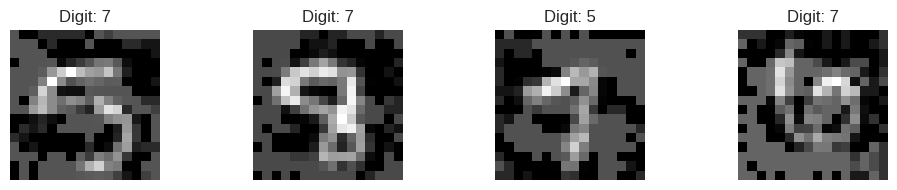

In [39]:
# PyTorch MNIST Classifier for Selected Digits (Fully Self-Contained)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Configuration
digits = [5, 8, 7, 6]
n_px = 16
train_size = 1000
test_size = 200
batch_size = 64
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- DATASET ---
def get_dataset(digits=[3, 5], n_px=8, train_size=1000, test_size=200):
    transform = transforms.ToTensor()
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    def filter_and_resize(dataset, digits, size, n_px):
        data = [(img, label) for img, label in dataset if label in digits]
        np.random.shuffle(data)
        data = data[:size]

        imgs, labels = zip(*data)
        resized_imgs = []
        for img in imgs:
            img_pil = transforms.ToPILImage()(img)
            img_resized = transforms.Resize((n_px, n_px))(img_pil)
            resized_imgs.append(transforms.ToTensor()(img_resized))

        x = torch.stack(resized_imgs)
        y = torch.tensor([digits.index(label) for label in labels])
        return x, y

    x_train, y_train = filter_and_resize(mnist_train, digits, train_size, n_px)
    x_test, y_test = filter_and_resize(mnist_test, digits, test_size, n_px)
    return (x_train, y_train), (x_test, y_test)

# --- VISUALIZATION ---
def visualise_data(digits, x_data, y_data):
    fig, axes = plt.subplots(1, len(digits), figsize=(10, 2))
    for i, ax in enumerate(axes):
        ax.imshow(x_data[i].squeeze(), cmap='gray')
        ax.set_title(f"Digit: {digits[y_data[i]]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Load dataset
(x_train, y_train), (x_test, y_test) = get_dataset(digits=digits, n_px=n_px)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

x_vis = [x_train[y_train == i][torch.randint(0, 10, (1,))] for i in range(len(digits))]
y_vis = list(range(len(digits)))
x_vis_torch = torch.cat(x_vis).to(device)
y_vis_torch = torch.tensor(y_vis).to(device)
visualise_data(digits, x_vis, y_vis)

# --- MODEL ---
class ClassicalCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * (n_px // 2) * (n_px // 2), 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.fc1(x), dim=1)

# --- TRAINING ---
def train(model, loader, optimizer, criterion):
    model.train()
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# --- TESTING ---
def test(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    accuracy = correct / len(loader.dataset)
    print(f'Test Accuracy: {accuracy:.4f}')

# --- PGD ATTACK ---
def PGD(model, feats, labels, epsilon=0.1, alpha=0.1, num_iter=10):
    delta = torch.zeros_like(feats, requires_grad=True)
    for t in range(num_iter):
        feats_adv = feats + delta
        outputs = [model(f.unsqueeze(0)) for f in feats_adv]
        l = nn.NLLLoss()(torch.stack(outputs).squeeze(), labels)
        l.backward()
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()
    return delta.detach()

# --- RUN ---
model = ClassicalCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train(model, train_loader, optimizer, criterion)
    test(model, test_loader)

# PGD Attack and Visualization
perturbations = PGD(model=model, feats=x_vis_torch, labels=y_vis_torch, epsilon=0.2)
perturbed_x = x_vis_torch + perturbations
adversarial_preds = [model(f.unsqueeze(0)) for f in perturbed_x]
adversarial_class_output = [torch.argmax(p).item() for p in adversarial_preds]
visualise_data(digits, perturbed_x.reshape(-1, n_px, n_px).cpu(), adversarial_class_output)


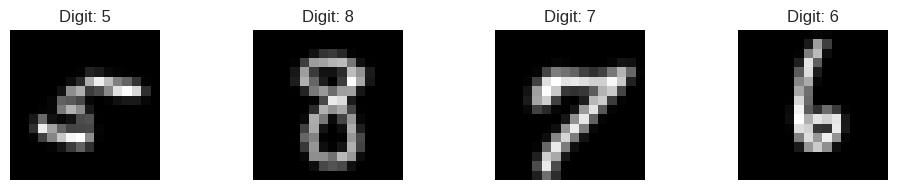

Epoch 1/10
Test Accuracy: 0.8600
Epoch 2/10
Test Accuracy: 0.9100
Epoch 3/10
Test Accuracy: 0.9200
Epoch 4/10
Test Accuracy: 0.9400
Epoch 5/10
Test Accuracy: 0.9550
Epoch 6/10
Test Accuracy: 0.9550
Epoch 7/10
Test Accuracy: 0.9600
Epoch 8/10
Test Accuracy: 0.9650
Epoch 9/10
Test Accuracy: 0.9650
Epoch 10/10
Test Accuracy: 0.9650


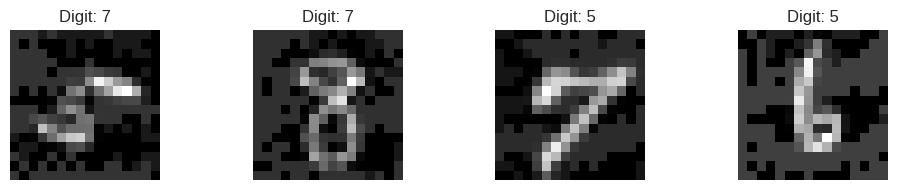

Clean Accuracy on x_vis: 1.0000
Adversarial Accuracy on x_vis (PGD): 0.0000


In [41]:
# PyTorch MNIST Classifier for Selected Digits (Fully Self-Contained)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Configuration
digits = [5, 8, 7, 6]
n_px = 16
train_size = 1000
test_size = 200
batch_size = 64
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- DATASET ---
def get_dataset(digits=[3, 5], n_px=8, train_size=1000, test_size=200):
    transform = transforms.ToTensor()
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    def filter_and_resize(dataset, digits, size, n_px):
        data = [(img, label) for img, label in dataset if label in digits]
        np.random.shuffle(data)
        data = data[:size]

        imgs, labels = zip(*data)
        resized_imgs = []
        for img in imgs:
            img_pil = transforms.ToPILImage()(img)
            img_resized = transforms.Resize((n_px, n_px))(img_pil)
            resized_imgs.append(transforms.ToTensor()(img_resized))

        x = torch.stack(resized_imgs)
        y = torch.tensor([digits.index(label) for label in labels])
        return x, y

    x_train, y_train = filter_and_resize(mnist_train, digits, train_size, n_px)
    x_test, y_test = filter_and_resize(mnist_test, digits, test_size, n_px)
    return (x_train, y_train), (x_test, y_test)

# --- VISUALIZATION ---
def visualise_data(digits, x_data, y_data):
    fig, axes = plt.subplots(1, len(digits), figsize=(10, 2))
    for i, ax in enumerate(axes):
        ax.imshow(x_data[i].squeeze(), cmap='gray')
        ax.set_title(f"Digit: {digits[y_data[i]]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Load dataset
(x_train, y_train), (x_test, y_test) = get_dataset(digits=digits, n_px=n_px)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

x_vis = [x_train[y_train == i][torch.randint(0, 10, (1,))] for i in range(len(digits))]
y_vis = list(range(len(digits)))
x_vis_torch = torch.cat(x_vis).to(device)
y_vis_torch = torch.tensor(y_vis).to(device)
visualise_data(digits, x_vis, y_vis)

# --- MODEL ---
class ClassicalCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * (n_px // 2) * (n_px // 2), 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.fc1(x), dim=1)

# --- TRAINING ---
def train(model, loader, optimizer, criterion):
    model.train()
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# --- TESTING ---
def test(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    accuracy = correct / len(loader.dataset)
    print(f'Test Accuracy: {accuracy:.4f}')
    return accuracy

# --- PGD ATTACK ---
def PGD(model, feats, labels, epsilon=0.1, alpha=0.1, num_iter=10):
    delta = torch.zeros_like(feats, requires_grad=True)
    for t in range(num_iter):
        feats_adv = feats + delta
        outputs = [model(f.unsqueeze(0)) for f in feats_adv]
        l = nn.NLLLoss()(torch.stack(outputs).squeeze(), labels)
        l.backward()
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()
    return delta.detach()

# --- RUN ---
model = ClassicalCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train(model, train_loader, optimizer, criterion)
    test(model, test_loader)

# PGD Attack and Visualization
perturbations = PGD(model=model, feats=x_vis_torch, labels=y_vis_torch, epsilon=0.1)
perturbed_x = x_vis_torch + perturbations
adversarial_preds = [model(f.unsqueeze(0)) for f in perturbed_x]
adversarial_class_output = [torch.argmax(p).item() for p in adversarial_preds]
visualise_data(digits, perturbed_x.reshape(-1, n_px, n_px).cpu(), adversarial_class_output)

# --- Comparison: Clean vs Adversarial Accuracy ---
model.eval()
with torch.no_grad():
    clean_output = model(x_vis_torch)
    clean_pred = clean_output.argmax(dim=1)
    clean_acc = (clean_pred == y_vis_torch).float().mean().item()

    adv_output = model(perturbed_x)
    adv_pred = adv_output.argmax(dim=1)
    adv_acc = (adv_pred == y_vis_torch).float().mean().item()

print(f"Clean Accuracy on x_vis: {clean_acc:.4f}")
print(f"Adversarial Accuracy on x_vis (PGD): {adv_acc:.4f}")


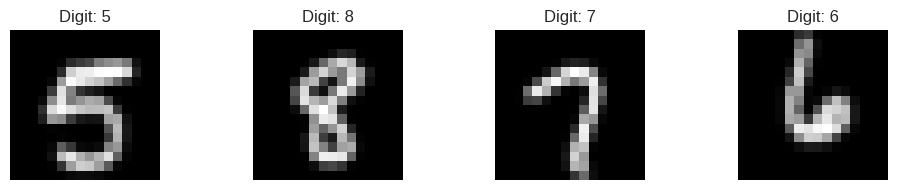

Training CNN Model
Epoch 1/10
Test Accuracy: 0.7150
Epoch 2/10
Test Accuracy: 0.9200
Epoch 3/10
Test Accuracy: 0.9250
Epoch 4/10
Test Accuracy: 0.9400
Epoch 5/10
Test Accuracy: 0.9600
Epoch 6/10
Test Accuracy: 0.9650
Epoch 7/10
Test Accuracy: 0.9600
Epoch 8/10
Test Accuracy: 0.9600
Epoch 9/10
Test Accuracy: 0.9650
Epoch 10/10
Test Accuracy: 0.9700


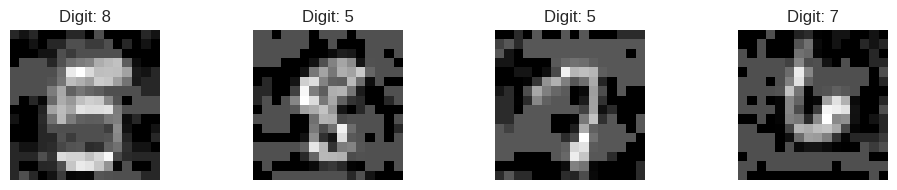

[CNN] Clean Accuracy on x_vis: 1.0000
[CNN] Adversarial Accuracy on x_vis (PGD): 0.0000
Training Simple FCNN Model
Epoch 1/10
Test Accuracy: 0.5550
Epoch 2/10
Test Accuracy: 0.7150
Epoch 3/10
Test Accuracy: 0.8550
Epoch 4/10
Test Accuracy: 0.8950
Epoch 5/10
Test Accuracy: 0.9100
Epoch 6/10
Test Accuracy: 0.9150
Epoch 7/10
Test Accuracy: 0.9200
Epoch 8/10
Test Accuracy: 0.9250
Epoch 9/10
Test Accuracy: 0.9350
Epoch 10/10
Test Accuracy: 0.9350
[FCNN] Clean Accuracy on x_vis: 1.0000
[FCNN] Adversarial Accuracy on x_vis (PGD): 0.0000


In [42]:
# PyTorch MNIST Classifier for Selected Digits (Fully Self-Contained)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Configuration
digits = [5, 8, 7, 6]
n_px = 16
train_size = 1000
test_size = 200
batch_size = 64
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- DATASET ---
def get_dataset(digits=[3, 5], n_px=8, train_size=1000, test_size=200):
    transform = transforms.ToTensor()
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    def filter_and_resize(dataset, digits, size, n_px):
        data = [(img, label) for img, label in dataset if label in digits]
        np.random.shuffle(data)
        data = data[:size]

        imgs, labels = zip(*data)
        resized_imgs = []
        for img in imgs:
            img_pil = transforms.ToPILImage()(img)
            img_resized = transforms.Resize((n_px, n_px))(img_pil)
            resized_imgs.append(transforms.ToTensor()(img_resized))

        x = torch.stack(resized_imgs)
        y = torch.tensor([digits.index(label) for label in labels])
        return x, y

    x_train, y_train = filter_and_resize(mnist_train, digits, train_size, n_px)
    x_test, y_test = filter_and_resize(mnist_test, digits, test_size, n_px)
    return (x_train, y_train), (x_test, y_test)

# --- VISUALIZATION ---
def visualise_data(digits, x_data, y_data):
    fig, axes = plt.subplots(1, len(digits), figsize=(10, 2))
    for i, ax in enumerate(axes):
        ax.imshow(x_data[i].squeeze(), cmap='gray')
        ax.set_title(f"Digit: {digits[y_data[i]]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Load dataset
(x_train, y_train), (x_test, y_test) = get_dataset(digits=digits, n_px=n_px)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

x_vis = [x_train[y_train == i][torch.randint(0, 10, (1,))] for i in range(len(digits))]
y_vis = list(range(len(digits)))
x_vis_torch = torch.cat(x_vis).to(device)
y_vis_torch = torch.tensor(y_vis).to(device)
visualise_data(digits, x_vis, y_vis)

# --- MODELS ---
class ClassicalCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * (n_px // 2) * (n_px // 2), 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.fc1(x), dim=1)

class SimpleFCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(n_px * n_px, 32)  # smaller intermediate layer
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# --- TRAINING ---
def train(model, loader, optimizer, criterion):
    model.train()
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# --- TESTING ---
def test(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    accuracy = correct / len(loader.dataset)
    print(f'Test Accuracy: {accuracy:.4f}')
    return accuracy

# --- PGD ATTACK ---
def PGD(model, feats, labels, epsilon=0.1, alpha=0.1, num_iter=10):
    delta = torch.zeros_like(feats, requires_grad=True)
    for t in range(num_iter):
        feats_adv = feats + delta
        outputs = [model(f.unsqueeze(0)) for f in feats_adv]
        l = nn.NLLLoss()(torch.stack(outputs).squeeze(), labels)
        l.backward()
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()
    return delta.detach()

# --- RUN (CNN MODEL) ---
model = ClassicalCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

print("Training CNN Model")
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train(model, train_loader, optimizer, criterion)
    test(model, test_loader)

# PGD Attack and Visualization
perturbations = PGD(model=model, feats=x_vis_torch, labels=y_vis_torch, epsilon=0.2)
perturbed_x = x_vis_torch + perturbations
adversarial_preds = [model(f.unsqueeze(0)) for f in perturbed_x]
adversarial_class_output = [torch.argmax(p).item() for p in adversarial_preds]
visualise_data(digits, perturbed_x.reshape(-1, n_px, n_px).cpu(), adversarial_class_output)

# --- Comparison: Clean vs Adversarial Accuracy (CNN) ---
model.eval()
with torch.no_grad():
    clean_output = model(x_vis_torch)
    clean_pred = clean_output.argmax(dim=1)
    clean_acc = (clean_pred == y_vis_torch).float().mean().item()

    adv_output = model(perturbed_x)
    adv_pred = adv_output.argmax(dim=1)
    adv_acc = (adv_pred == y_vis_torch).float().mean().item()

print(f"[CNN] Clean Accuracy on x_vis: {clean_acc:.4f}")
print(f"[CNN] Adversarial Accuracy on x_vis (PGD): {adv_acc:.4f}")

# --- RUN (FC MODEL) ---
fc_model = SimpleFCNN().to(device)
fc_optimizer = optim.Adam(fc_model.parameters(), lr=0.001)

print("Training Simple FCNN Model")
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train(fc_model, train_loader, fc_optimizer, criterion)
    test(fc_model, test_loader)

# --- FC Accuracy Comparison ---
fc_model.eval()
with torch.no_grad():
    clean_output_fc = fc_model(x_vis_torch)
    clean_pred_fc = clean_output_fc.argmax(dim=1)
    clean_acc_fc = (clean_pred_fc == y_vis_torch).float().mean().item()

    adv_output_fc = fc_model(perturbed_x)
    adv_pred_fc = adv_output_fc.argmax(dim=1)
    adv_acc_fc = (adv_pred_fc == y_vis_torch).float().mean().item()

print(f"[FCNN] Clean Accuracy on x_vis: {clean_acc_fc:.4f}")
print(f"[FCNN] Adversarial Accuracy on x_vis (PGD): {adv_acc_fc:.4f}")


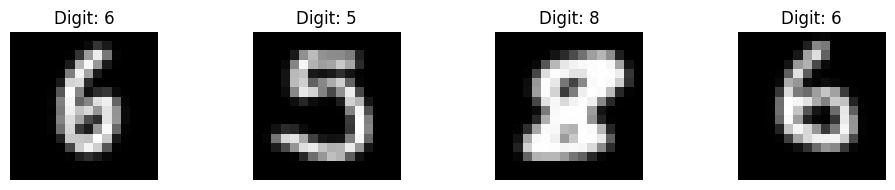

Training CNN Model
Epoch 1/10
Test Accuracy: 0.7450
Epoch 2/10
Test Accuracy: 0.8750
Epoch 3/10
Test Accuracy: 0.8950
Epoch 4/10
Test Accuracy: 0.9050
Epoch 5/10
Test Accuracy: 0.9200
Epoch 6/10
Test Accuracy: 0.9200
Epoch 7/10
Test Accuracy: 0.9100
Epoch 8/10
Test Accuracy: 0.9300
Epoch 9/10
Test Accuracy: 0.9300
Epoch 10/10
Test Accuracy: 0.9450


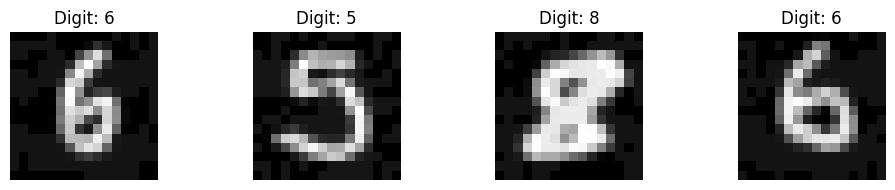

[CNN] Clean Accuracy on x_vis: 0.9531
[CNN] Adversarial Accuracy on x_vis (PGD): 0.8125
Training Simple FCNN Model
Epoch 1/10
Test Accuracy: 0.7000
Epoch 2/10
Test Accuracy: 0.7700
Epoch 3/10
Test Accuracy: 0.8650
Epoch 4/10
Test Accuracy: 0.8850
Epoch 5/10
Test Accuracy: 0.9100
Epoch 6/10
Test Accuracy: 0.9150
Epoch 7/10
Test Accuracy: 0.9300
Epoch 8/10
Test Accuracy: 0.9350
Epoch 9/10
Test Accuracy: 0.9350
Epoch 10/10
Test Accuracy: 0.9400
[FCNN] Clean Accuracy on x_vis: 0.9531
[FCNN] Adversarial Accuracy on x_vis (PGD): 0.7500


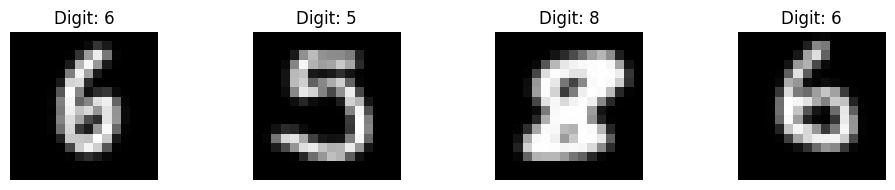

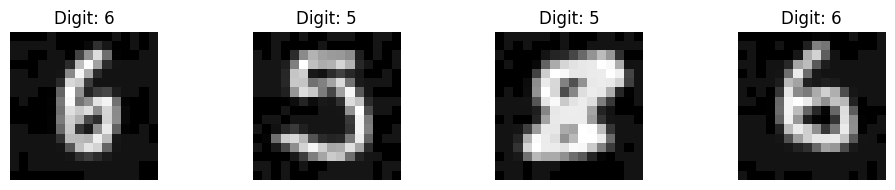

In [1]:
# PyTorch MNIST Classifier for Selected Digits (Fully Self-Contained)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Configuration
digits = [5, 8, 7, 6]
n_px = 16
train_size = 1000
test_size = 200
batch_size = 64
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- DATASET ---
def get_dataset(digits=[3, 5], n_px=8, train_size=1000, test_size=200):
    transform = transforms.ToTensor()
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    def filter_and_resize(dataset, digits, size, n_px):
        data = [(img, label) for img, label in dataset if label in digits]
        np.random.shuffle(data)
        data = data[:size]

        imgs, labels = zip(*data)
        resized_imgs = []
        for img in imgs:
            img_pil = transforms.ToPILImage()(img)
            img_resized = transforms.Resize((n_px, n_px))(img_pil)
            resized_imgs.append(transforms.ToTensor()(img_resized))

        x = torch.stack(resized_imgs)
        y = torch.tensor([digits.index(label) for label in labels])
        return x, y

    x_train, y_train = filter_and_resize(mnist_train, digits, train_size, n_px)
    x_test, y_test = filter_and_resize(mnist_test, digits, test_size, n_px)
    return (x_train, y_train), (x_test, y_test)

# --- VISUALIZATION ---
def visualise_data(digits, x_data, y_data):
    fig, axes = plt.subplots(1, len(digits), figsize=(10, 2))
    for i, ax in enumerate(axes):
        ax.imshow(x_data[i].squeeze(), cmap='gray')
        ax.set_title(f"Digit: {digits[y_data[i]]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Load dataset
(x_train, y_train), (x_test, y_test) = get_dataset(digits=digits, n_px=n_px)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Select multiple test samples for visualization and PGD attack
x_vis_torch = x_test[:64].to(device)
y_vis_torch = y_test[:64].to(device)
visualise_data(digits, x_vis_torch.cpu(), y_vis_torch.cpu())

# --- MODELS ---
class ClassicalCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * (n_px // 2) * (n_px // 2), 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.fc1(x), dim=1)

class SimpleFCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(n_px * n_px, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# --- TRAINING ---
def train(model, loader, optimizer, criterion):
    model.train()
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# --- TESTING ---
def test(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    accuracy = correct / len(loader.dataset)
    print(f'Test Accuracy: {accuracy:.4f}')
    return accuracy

# --- PGD ATTACK ---
def PGD(model, feats, labels, epsilon=0.1, alpha=0.1, num_iter=10):
    delta = torch.zeros_like(feats, requires_grad=True)
    for t in range(num_iter):
        feats_adv = feats + delta
        output = model(feats_adv)
        l = nn.NLLLoss()(output, labels)
        l.backward()
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()
    return delta.detach()

# --- RUN (CNN MODEL) ---
model = ClassicalCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

print("Training CNN Model")
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train(model, train_loader, optimizer, criterion)
    test(model, test_loader)

perturbations = PGD(model=model, feats=x_vis_torch, labels=y_vis_torch, epsilon=0.04)
perturbed_x = x_vis_torch + perturbations

adversarial_preds = model(perturbed_x).argmax(dim=1)
visualise_data(digits, perturbed_x[:len(digits)].reshape(-1, n_px, n_px).cpu(), adversarial_preds[:len(digits)].cpu())

# --- Comparison: Clean vs Adversarial Accuracy (CNN) ---
model.eval()
with torch.no_grad():
    clean_output = model(x_vis_torch)
    clean_pred = clean_output.argmax(dim=1)
    clean_acc = (clean_pred == y_vis_torch).float().mean().item()

    adv_output = model(perturbed_x)
    adv_pred = adv_output.argmax(dim=1)
    adv_acc = (adv_pred == y_vis_torch).float().mean().item()

print(f"[CNN] Clean Accuracy on x_vis: {clean_acc:.4f}")
print(f"[CNN] Adversarial Accuracy on x_vis (PGD): {adv_acc:.4f}")

# --- RUN (FC MODEL) ---
fc_model = SimpleFCNN().to(device)
fc_optimizer = optim.Adam(fc_model.parameters(), lr=0.001)

print("Training Simple FCNN Model")
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train(fc_model, train_loader, fc_optimizer, criterion)
    test(fc_model, test_loader)

fc_model.eval()
with torch.no_grad():
    clean_output_fc = fc_model(x_vis_torch)
    clean_pred_fc = clean_output_fc.argmax(dim=1)
    clean_acc_fc = (clean_pred_fc == y_vis_torch).float().mean().item()

    adv_output_fc = fc_model(perturbed_x)
    adv_pred_fc = adv_output_fc.argmax(dim=1)
    adv_acc_fc = (adv_pred_fc == y_vis_torch).float().mean().item()

print(f"[FCNN] Clean Accuracy on x_vis: {clean_acc_fc:.4f}")
print(f"[FCNN] Adversarial Accuracy on x_vis (PGD): {adv_acc_fc:.4f}")

# Visualize Clean Predictions vs Adversarial for FCNN
visualise_data(digits, x_vis_torch[:len(digits)].cpu(), clean_pred_fc[:len(digits)].cpu())
visualise_data(digits, perturbed_x[:len(digits)].cpu(), adv_pred_fc[:len(digits)].cpu())


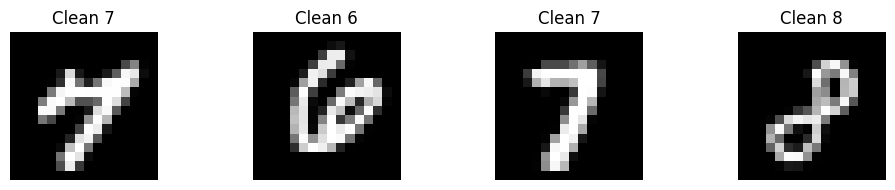

Training CNN model...
CNN Clean Test Acc: 0.9550
CNN Adversarial (PGD) Acc on subset: 0.6250


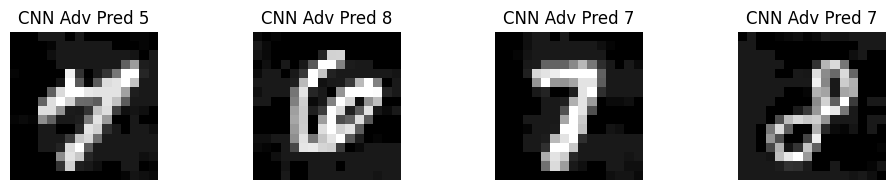

Training FC model...
FC Clean Test Acc: 0.9400
FC Adversarial (PGD) Acc on subset: 0.4062


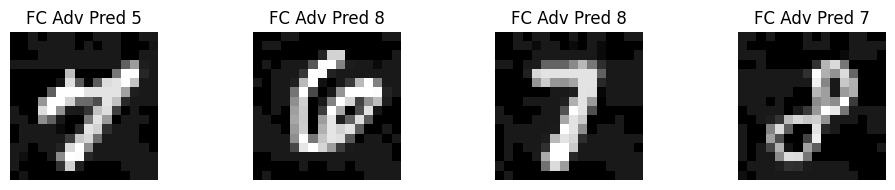

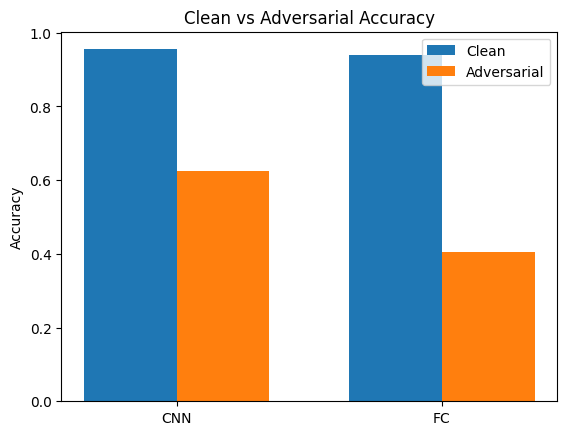

In [2]:
# PyTorch MNIST Classifier for Selected Digits (Fully Self-Contained)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

# Configuration
digits = [5, 8, 7, 6]
n_px = 16
train_size = 1000
test_size = 200
batch_size = 64
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- DATASET (using raw MNIST tensors, avoids PIL/ToTensor issues) ---
def get_dataset(digits=[3, 5], n_px=8, train_size=1000, test_size=200):
    # Load raw data (uint8 [0-255])
    mnist_train = datasets.MNIST(root='./data', train=True, download=True)
    mnist_test = datasets.MNIST(root='./data', train=False, download=True)

    # Helper: filter, sample, normalize, resize
    def prepare(data, targets, digits, size, n_px):
        # Filter by class
        mask = torch.zeros_like(targets, dtype=torch.bool)
        for d in digits:
            mask |= (targets == d)
        data_f = data[mask]
        targ_f = targets[mask]

        # Sample 'size' examples
        idx = torch.randperm(len(data_f))[:size]
        imgs = data_f[idx].unsqueeze(1).float() / 255.0  # [size,1,28,28]
        labs = targ_f[idx]

        # Resize to n_px x n_px
        imgs_resized = F.interpolate(imgs, size=(n_px, n_px), mode='bilinear', align_corners=False)
        # Map labels to 0..len(digits)-1
        labs_mapped = torch.tensor([digits.index(int(l)) for l in labs])
        return imgs_resized, labs_mapped

    x_train, y_train = prepare(mnist_train.data, mnist_train.targets, digits, train_size, n_px)
    x_test, y_test   = prepare(mnist_test.data, mnist_test.targets,   digits, test_size,  n_px)
    return (x_train, y_train), (x_test, y_test)

# --- VISUALIZATION ---
def visualise_data(digits, x_data, y_data, title_prefix=""):
    # x_data: [N,1,H,W], y_data: [N]
    n = len(digits)
    fig, axes = plt.subplots(1, n, figsize=(10, 2))
    for i, ax in enumerate(axes):
        ax.imshow(x_data[i].squeeze(), cmap='gray')
        ax.set_title(f"{title_prefix} {digits[y_data[i]]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Load and prepare dataset
(x_train, y_train), (x_test, y_test) = get_dataset(digits=digits, n_px=n_px)
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(TensorDataset(x_test,  y_test),  batch_size=batch_size)

# Select test subset for visualization and PGD
x_vis = x_test[:64].to(device)
y_vis = y_test[:64].to(device)
visualise_data(digits, x_vis.cpu(), y_vis.cpu(), title_prefix="Clean")

# --- MODELS ---
class ClassicalCNN(nn.Module):
    def __init__(self, n_px, n_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * (n_px // 2) * (n_px // 2), n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.fc1(x), dim=1)

class SimpleFCNN(nn.Module):
    def __init__(self, n_px, n_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(n_px * n_px, 32)
        self.fc2 = nn.Linear(32, n_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# --- TRAIN / TEST ---
def train(model, loader, optimizer, criterion):
    model.train()
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        loss = criterion(model(data), target)
        loss.backward()
        optimizer.step()


def test(model, loader):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            pred = model(data).argmax(dim=1)
            total += target.size(0)
            correct += pred.eq(target).sum().item()
    return correct / total

# --- PGD ATTACK ---
def PGD(model, x, y, epsilon=0.1, alpha=0.01, num_iter=10):
    x_orig = x.detach()
    delta = torch.zeros_like(x_orig, requires_grad=True)
    for _ in range(num_iter):
        output = model(x_orig + delta)
        loss = nn.NLLLoss()(output, y)
        loss.backward()
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()
    adv_x = torch.clamp(x_orig + delta.detach(), 0, 1)
    return adv_x

# --- RUN (Compare CNN vs FCNN) ---
n_classes = len(digits)

results = {}
for name, net in [("CNN", ClassicalCNN(n_px, n_classes)), ("FC", SimpleFCNN(n_px, n_classes))]:
    model = net.to(device)
    opt = optim.Adam(model.parameters(), lr=0.001)
    crit = nn.NLLLoss()

    print(f"Training {name} model...")
    for epoch in range(epochs):
        train(model, train_loader, opt, crit)
    acc_clean = test(model, test_loader)
    print(f"{name} Clean Test Acc: {acc_clean:.4f}")

    adv = PGD(model, x_vis, y_vis, epsilon=0.1)
    acc_adv = (model(adv).argmax(1) == y_vis).float().mean().item()
    print(f"{name} Adversarial (PGD) Acc on subset: {acc_adv:.4f}")

    # Visualize a few
    visualise_data(digits, adv.cpu(), model(adv).argmax(1).cpu(), title_prefix=f"{name} Adv Pred")
    results[name] = (acc_clean, acc_adv)

# Summary Plot
labels = list(results.keys())
clean_vals = [results[k][0] for k in labels]
adv_vals   = [results[k][1] for k in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, clean_vals, width, label='Clean')
ax.bar(x + width/2, adv_vals,   width, label='Adversarial')
ax.set_ylabel('Accuracy')
ax.set_title('Clean vs Adversarial Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()


### Accuracy v/s epochs

In [4]:
# PyTorch MNIST Classifier: Epoch-wise Accuracy Tracking
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

# Configuration
digits = [5, 8, 7, 6]
n_px = 16
train_size = 1000
test_size = 200
batch_size = 64
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- DATASET ---
def get_dataset(digits, n_px, train_size, test_size):
    mnist_train = datasets.MNIST(root='./data', train=True, download=True)
    mnist_test  = datasets.MNIST(root='./data', train=False, download=True)
    def prepare(data, targets, size):
        mask = sum([(targets==d) for d in digits])
        data_f = data[mask]; targ_f = targets[mask]
        idx = torch.randperm(len(data_f))[:size]
        imgs = data_f[idx].unsqueeze(1).float()/255.0
        imgs = F.interpolate(imgs, size=(n_px,n_px), mode='bilinear', align_corners=False)
        labels = torch.tensor([digits.index(int(l)) for l in targ_f[idx]])
        return imgs.to(device), labels.to(device)
    x_train,y_train = prepare(mnist_train.data, mnist_train.targets, train_size)
    x_test, y_test  = prepare(mnist_test.data,  mnist_test.targets,  test_size)
    return (x_train,y_train),(x_test,y_test)

# Load data and create loader
(x_train,y_train),(x_test,y_test) = get_dataset(digits, n_px, train_size, test_size)
train_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(TensorDataset(x_test, y_test),  batch_size=batch_size)

# --- MODELS ---
class ClassicalCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1,32,3,padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc   = nn.Linear(32*(n_px//2)*(n_px//2), len(digits))
    def forward(self,x): return F.log_softmax(self.fc(self.pool(F.relu(self.conv(x)))).view(x.size(0),-1), dim=1)

class SimpleFCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(n_px*n_px,32)
        self.fc2 = nn.Linear(32,len(digits))
    def forward(self,x): return F.log_softmax(self.fc2(F.relu(self.fc1(self.flatten(x)))), dim=1)

# --- TRAIN & TEST FUNCTIONS ---
def train_epoch(model,opt,crit,loader):
    model.train()
    for x,y in loader:
        opt.zero_grad(); loss=crit(model(x),y); loss.backward(); opt.step()

def eval_accuracy(model,loader):
    model.eval(); correct=0; total=0
    with torch.no_grad():
        for x,y in loader:
            pred=model(x).argmax(1)
            correct+=pred.eq(y).sum().item()
            total+=y.size(0)
    return correct/total

# --- PGD ATTACK ---
def PGD(model,x,y,epsilon=0.1,alpha=0.01,iters=10):
    x0=x.detach(); delta=torch.zeros_like(x0,requires_grad=True)
    for _ in range(iters):
        loss=nn.NLLLoss()(model(x0+delta),y); loss.backward()
        delta.data=(delta+alpha*delta.grad.sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return torch.clamp(x0+delta.detach(),0,1)

# --- Run: track accuracy per epoch ---
results = { 'CNN': {'clean':[], 'adv':[]}, 'FC': {'clean':[], 'adv':[]} }
# test subset for adversarial evaluation
y_vis = y_test[:batch_size]; x_vis = x_test[:batch_size]

for name, Model in [('CNN',ClassicalCNN), ('FC',SimpleFCNN)]:
    model = Model().to(device)
    opt   = optim.Adam(model.parameters(), lr=1e-3)
    crit  = nn.NLLLoss()
    for ep in range(1, epochs+1):
        train_epoch(model,opt,crit,train_loader)
        acc_clean = eval_accuracy(model, test_loader)
        adv_x = PGD(model, x_vis, y_vis, epsilon=0.1, alpha=0.01, iters=10)
        acc_adv = (model(adv_x).argmax(1)==y_vis).float().mean().item()
        results[name]['clean'].append(acc_clean)
        results[name]['adv'].append(acc_adv)
        print(f"{name} Epoch {ep}: clean={acc_clean:.3f}, adv={acc_adv:.3f}")

# --- Plot accuracy vs epochs ---
epochs_range = np.arange(1, epochs+1)
plt.figure(figsize=(8,5))
for name in results:
    plt.plot(epochs_range:=epochs_range if False else epochs_range, results[name]['clean'], marker='o', label=f"{name} Clean")
    plt.plot(epochs_range, results[name]['adv'],   marker='x', label=f"{name} PGD Adv")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Clean vs Adversarial Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()


ValueError: 0 is not in list